In [70]:
#!pip install datasets

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm
from collections import Counter
#from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [72]:
imagenet_train = load_dataset('Maysee/tiny-imagenet', split='train')
imagenet_val_combined = load_dataset('Maysee/tiny-imagenet', split='valid')
imagenet_val_test = imagenet_val_combined.train_test_split(test_size=0.5, stratify_by_column='label')

imagenet_val = imagenet_val_test['train']
imagenet_test = imagenet_val_test['test']

182


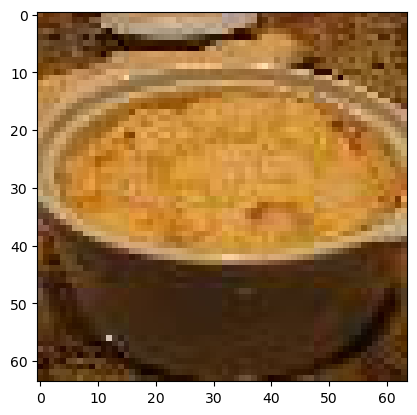

In [73]:
#plot imagenet_val[11]['image']
num = 44
print(imagenet_val[num]['label'])
plt.imshow(imagenet_val[num]['image'])

In [74]:
imagenet_test['label']
# count the number of images in each class
Counter([x['label'] for x in imagenet_test])

Counter({120: 25,
         76: 25,
         149: 25,
         61: 25,
         130: 25,
         68: 25,
         145: 25,
         46: 25,
         52: 25,
         115: 25,
         135: 25,
         105: 25,
         60: 25,
         1: 25,
         172: 25,
         69: 25,
         0: 25,
         28: 25,
         117: 25,
         161: 25,
         133: 25,
         122: 25,
         80: 25,
         136: 25,
         53: 25,
         184: 25,
         150: 25,
         167: 25,
         156: 25,
         94: 25,
         192: 25,
         32: 25,
         100: 25,
         179: 25,
         64: 25,
         49: 25,
         183: 25,
         6: 25,
         131: 25,
         4: 25,
         26: 25,
         134: 25,
         57: 25,
         124: 25,
         104: 25,
         143: 25,
         10: 25,
         44: 25,
         194: 25,
         158: 25,
         31: 25,
         173: 25,
         30: 25,
         71: 25,
         177: 25,
         34: 25,
         140: 25,
    

In [75]:
num_classes = 200  # All used

def filter_dataset(dataset, images_per_class=25, class_size=500):
    total_images = len(dataset)
    num_classes = total_images // class_size

    selected_indices = []
    rng = np.random.default_rng()  # Create a random number generator

    for class_idx in range(num_classes):
        start_idx = class_idx * class_size
        end_idx = start_idx + class_size
        
        # Randomly select indices from this class chunk
        class_indices = rng.choice(range(start_idx, end_idx), 
                                   size=images_per_class, 
                                   replace=False)
        
        selected_indices.extend(class_indices)

    # Shuffle the selected indices
    rng.shuffle(selected_indices)

    # Filter the dataset
    filtered_dataset = dataset.select(selected_indices)

    return filtered_dataset

# Apply the filtering to train
images_per_class = 25
imagenet_train = filter_dataset(imagenet_train, images_per_class=images_per_class)

In [98]:
shape = imagenet_train[2]['image'].size

In [101]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.to(device)

from torchsummary import summary
summary(model, (3, *shape))
model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# replace the last conv 2d layer with a linear layer
new_layer = nn.Sequential(
    nn.ReLU(),
    nn.Linear(2, 2),
    nn.ReLU()
)
model.layer4[1].conv2 = new_layer

model.fc = nn.Linear(512, num_classes)

for param in model.layer4[1].conv2.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [ ]:
summary(model, (3, 64, 64))
model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [106]:
# Define the transformation pipeline for Tiny ImageNet

class ConvertToRGB:
    def __call__(self, image):
        if image.mode != 'RGB':  # Check if the image is grayscale
            image = image.convert("RGB")
        return image
    
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet stats
])

In [107]:
class TinyImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Data loaders
train_dataset = TinyImageNetDataset(imagenet_train, transform=transform)
val_dataset = TinyImageNetDataset(imagenet_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Training and evaluation functions
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Update counts for accuracy
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    print(f"Validation Accuracy: {accuracy:.4f}")
    return accuracy

In [108]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_accuracy = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

100%|██████████| 157/157 [00:20<00:00,  7.69it/s]


Validation Accuracy: 0.0146
Epoch 1, Train Loss: 5.3976, Val Accuracy: 0.0146


100%|██████████| 157/157 [00:15<00:00,  9.97it/s]


Validation Accuracy: 0.0222
Epoch 2, Train Loss: 5.2043, Val Accuracy: 0.0222


100%|██████████| 157/157 [00:17<00:00,  8.92it/s]


Validation Accuracy: 0.0426
Epoch 3, Train Loss: 5.0208, Val Accuracy: 0.0426


100%|██████████| 157/157 [00:17<00:00,  8.90it/s]


Validation Accuracy: 0.0876
Epoch 4, Train Loss: 4.7154, Val Accuracy: 0.0876


100%|██████████| 157/157 [00:18<00:00,  8.51it/s]


Validation Accuracy: 0.1598
Epoch 5, Train Loss: 3.9609, Val Accuracy: 0.1598


100%|██████████| 157/157 [00:16<00:00,  9.58it/s]


Validation Accuracy: 0.1998
Epoch 6, Train Loss: 2.9687, Val Accuracy: 0.1998


100%|██████████| 157/157 [00:15<00:00, 10.03it/s]


Validation Accuracy: 0.2126
Epoch 7, Train Loss: 2.2619, Val Accuracy: 0.2126


100%|██████████| 157/157 [00:18<00:00,  8.43it/s]


Validation Accuracy: 0.2238
Epoch 8, Train Loss: 1.7974, Val Accuracy: 0.2238


100%|██████████| 157/157 [00:16<00:00,  9.54it/s]


Validation Accuracy: 0.2274
Epoch 9, Train Loss: 1.4661, Val Accuracy: 0.2274


100%|██████████| 157/157 [00:16<00:00,  9.45it/s]


Validation Accuracy: 0.2216
Epoch 10, Train Loss: 1.2659, Val Accuracy: 0.2216
